# Classification of Pulsar Stars From the HTRU2 Data Set

In [1]:
# Loading in packages
library(tidyverse) # Meta package for reading and wrangling data
library(repr) # For effective data visualizations
library(tidymodels) # For classification and training

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Shiyu's feedback

### Nice work! Here are some advises for your final report.

##### It is essential to provide references in your report to validate the credibility of your project. Please include a minimum of two references in your report(I suggest more for your topic). Additionally, explain unfamiliar variables. For instance, you mentioned DM-SNR (Dispersion Measure - Signal to Noise Ratio) in your introduction, which is a crucial pattern for your model, but it was still unclear what it represents. Since you selected an unfamiliar dataset for most people, maybe data dictionaries can be more helpful.

##### You have identified variables to conduct your classification in the method section. Therefore, you should claim those variables in your research question at the beginning of your report. Explain why you selected those variables and how they contributed to your model. Did you choose them by the scatterplot matrix you made? What is the role of the box plots? Keep in mind that your readers may not have any knowledge of R and astronomy.

##### To make your code more accessible, consider breaking down the code cells into different sections and provide explanations for each part in your final report(visualization is not a big one but you can still break it). Explain why you designed your tables and graphs in a specific way. What does it represent? How does it relate to your later work?

##### Regarding visualization, reducing the transparency level of categorical graphs can help decrease overplotting and make the data more readable. Also, while you mentioned 0 or 1 for your class, please remind your readers what 0 and 1 represent, even if you mentioned them earlier.

##### Since you have graphs that can be used to compare (mean_pulsar_plot&deviation_pulsar_plot), it's a good idea to arrange them in a grid. You can use the plot_grid() function in the cowplot package to accomplish this. Displaying graphs side by side can help readers in reading and comparing them. Additionally, label your figures. This can be done using the plot_grid() function as well.

##### Your methodology section is sufficient for a proposal. However, there could be much more work to do in the final report. Thus, include more details and explanations in the final report to better convey what you're doing. Keep in mind that this topic may not be familiar to most people, so additional elaboration and detail are required. The goal is to make your report accessible to everyone, regardless of their familiarity with R and astronomy.

#### Instructions for the intro: 
##### - provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
##### - clearly state the question you tried to answer with your project
##### - identify and describe the dataset that was used to answer the question 

## 1) Introduction

This dataset classifies signal profiles as those from pulsars or from non-pulsars/noise. Pulsars are a type of rare neutron star that play important roles as predictors of space-time, inter-stellar mediums, and many more scientific realms. The data for the stars comes from the HTRU (High Time Resolution Universe) Survey. The pulsars are detected through periodic radio signals that have slight different emission patterns depending on rotation. However, sometimes detections of periodic radio signals are a result of RFI (radio frequency interference) and noise, which may make it more challenging to recognize a pulsar. This dataset explores integrated profile (averaged emission of periodic radio signals over many rotations) characteristics like mean, along with DM-SNR (Dispersion Measure - Signal to Noise Ratio) curve data to classify whether the signals were caused by pulsars or non-pulsars. Class 1 means that a pulsar was present, class 0 means that it was a non-pulsar.

Our project then aims to answer the question: **Can we use measurements from signal profiles to predict whether a future signal (of unknown class) is the result of a pulsar or non-pulsar?**

*Link to our dataset: https://archive.ics.uci.edu/ml/datasets/HTRU2#*

## 2) Methods and Results

#### Instructions for methods and results 

##### - describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
##### - your report should include code which:

- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
##### - note: all tables and figure should have a figure/table number and a legend

In [2]:
# Read the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "data/pulsardata.zip") 
unzip("data/pulsardata.zip") 
pulsar_data <- read_csv("HTRU_2.csv", col_names = FALSE) |>
    mutate(X9 = as_factor(X9))
colnames(pulsar_data) <- make.names(c("Mean of integrated profile" , "Standard deviation of the integrated profile",
                           "Excess kurtosis of the integrated profile", "Skewness of the integrated profile", 
                           "Mean of the DM-SNR curve", "Standard deviation of the DM-SNR curve", 
                           "Excess kurtosis of the DM-SNR curve", "Skewness of the DM-SNR curve", "Class"))
pulsar_data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Mean.of.integrated.profile,Standard.deviation.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Skewness.of.the.integrated.profile,Mean.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Excess.kurtosis.of.the.DM.SNR.curve,Skewness.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.234571412,-0.69964840,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.465318154,-0.51508791,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.323328365,1.05116443,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.068414638,-0.63623837,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.600866079,1.12349169,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.531904850,0.41672112,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.031460220,-0.11216757,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.158322759,0.38954045,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.452688025,0.17034738,2.3319398,14.486853,9.001004,107.97251,0


In [3]:
# Clean and wrangle the data
head(pulsar_data)
#Checking for any Null values;

pulsar_data <- pulsar_data |>
            drop_na()

Mean.of.integrated.profile,Standard.deviation.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Skewness.of.the.integrated.profile,Mean.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Excess.kurtosis.of.the.DM.SNR.curve,Skewness.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [4]:
# Summarize the data

pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = Class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

pulsar_summary <- pulsar_train  |>
    group_by(Class) |>
    summarise(count = n())

pulsar_summary


Class,count
<fct>,<int>
0,12206
1,1217


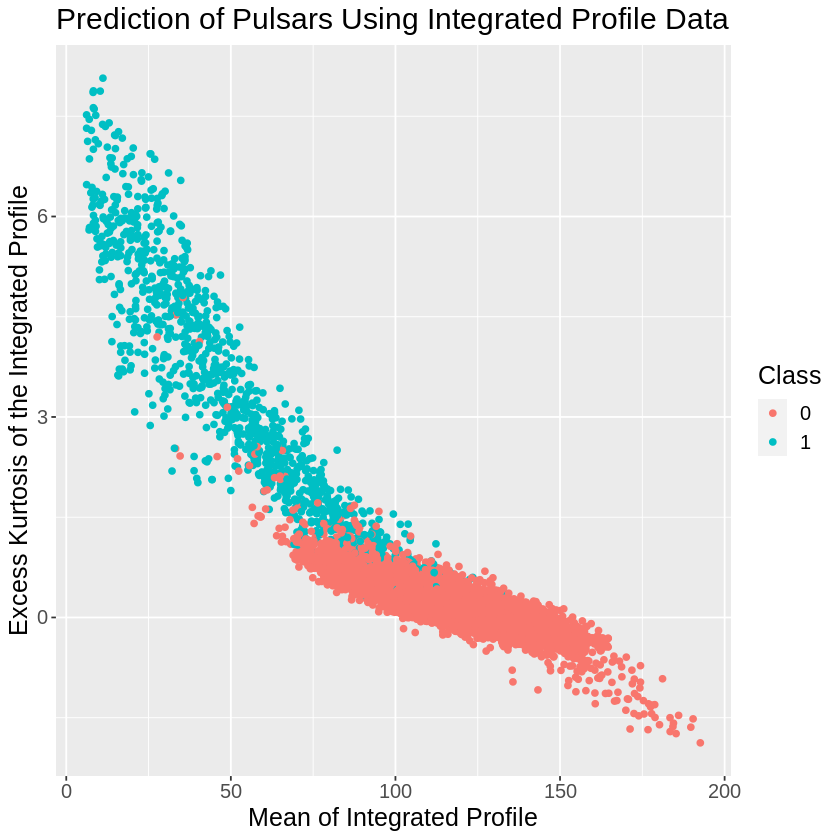

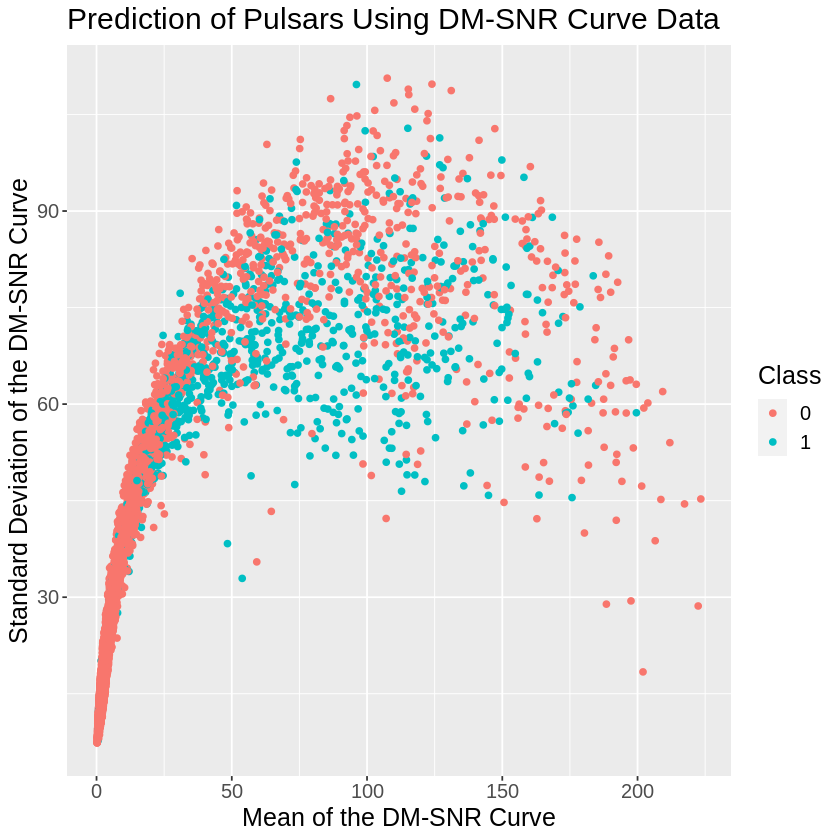

In [5]:
# Visualization
mean_pulsar_plot <- pulsar_train |>
            ggplot(aes(x = Mean.of.integrated.profile, y= Excess.kurtosis.of.the.integrated.profile, color = Class)) +
            geom_point() +
            xlab("Mean of Integrated Profile") + 
            ylab("Excess Kurtosis of the Integrated Profile") +
            ggtitle("Prediction of Pulsars Using Integrated Profile Data") + 
            theme(text = element_text(size = 15))

deviation_pulsar_plot <- pulsar_train |>
            ggplot(aes(x = Mean.of.the.DM.SNR.curve, y=Standard.deviation.of.the.DM.SNR.curve, color = Class)) +
            geom_point() +
            xlab("Mean of the DM-SNR Curve") + 
            ylab("Standard Deviation of the DM-SNR Curve") +
            ggtitle("Prediction of Pulsars Using DM-SNR Curve Data") +
            theme(text = element_text(size = 15))


    
mean_pulsar_plot
deviation_pulsar_plot

## Methods

## From Lily: this shouldn't be present in the final product as we will actually be doing our analysis using the methods discussed. Will leave it here for now in case we need it, especially for the variables 
**Explain how you will conduct either your data analysis and which variables/columns you will use.
Describe at least one way that you will visualize the results.**

We will conduct our data analysis by using the K-nearest neighbours classification algorithm and tuning our classifier using 5-fold cross-validation. 

To determine which variables/columns we'll use, we must first compare the differences in distribution of our classification category in context of each variable. 

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



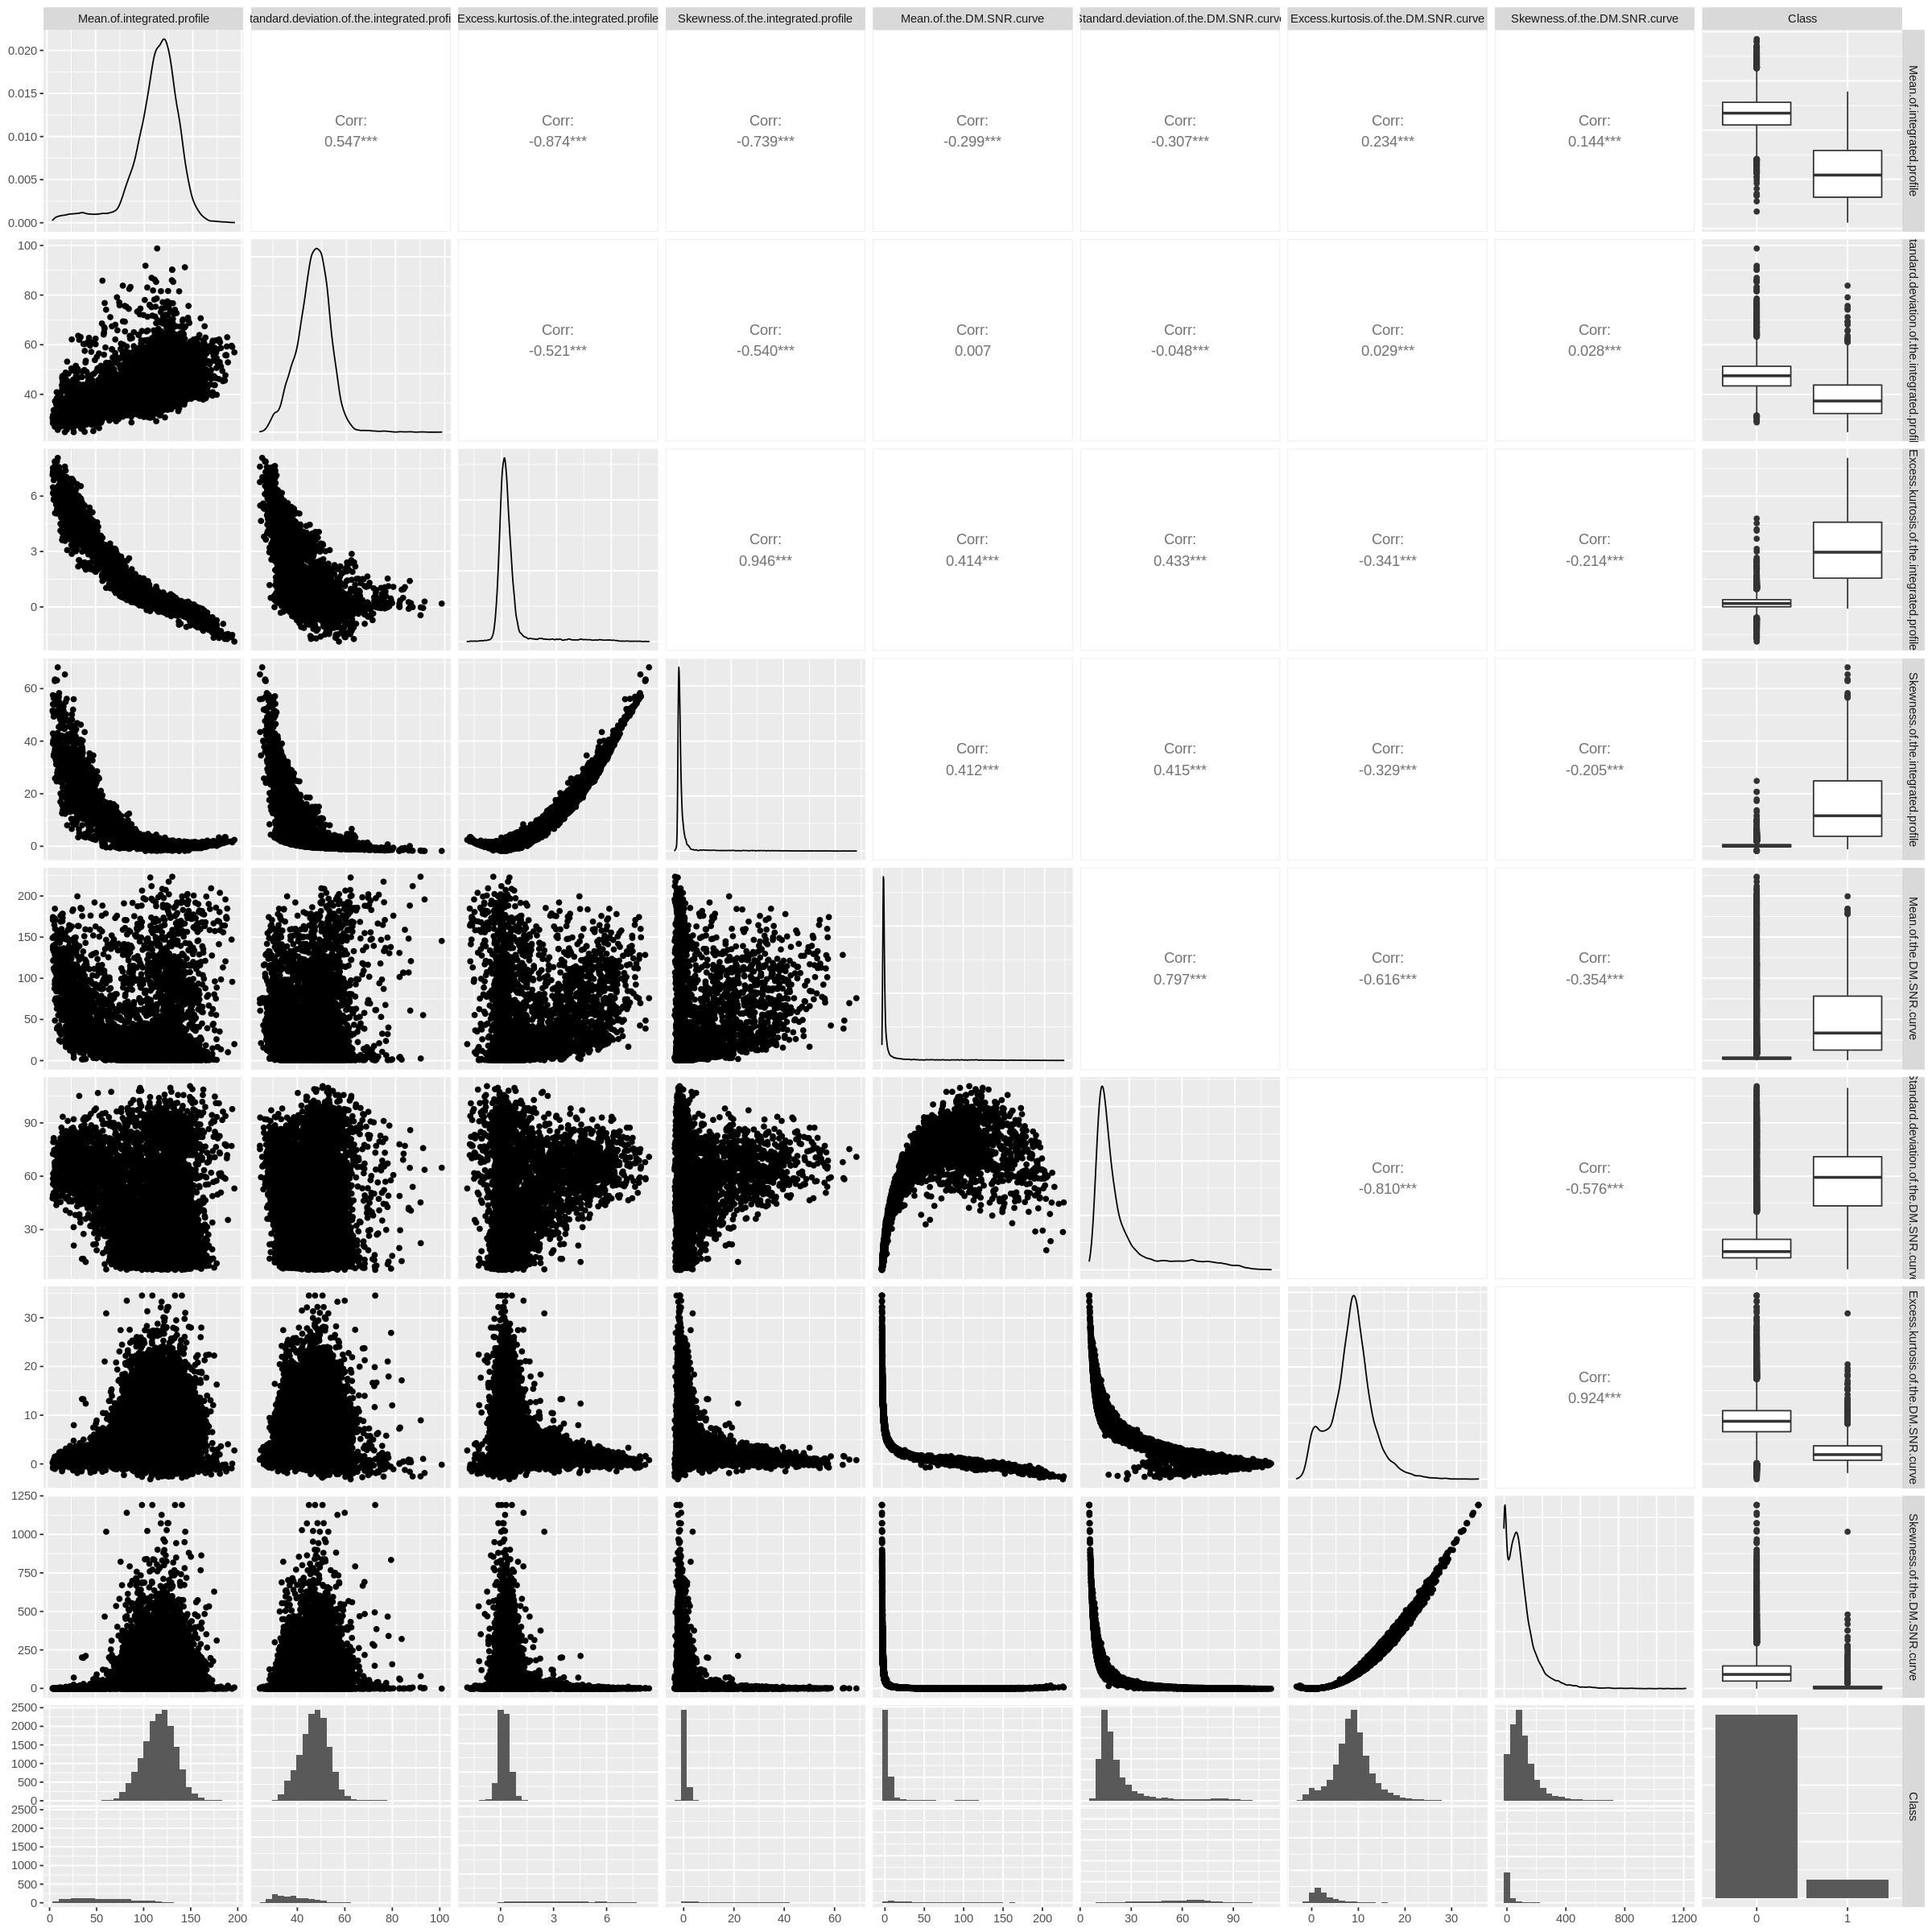

In [6]:
library(GGally)
options(repr.plot.width = 20, repr.plot.height = 20)
ggpairs(pulsar_data)

In the rightmost column, box plots have been generated to compare the statistics for each class. We have decided to use the following variables to conduct our classification: mean of integrated profile, excess kurtosis of integrated profile, mean of DM-SNR curve, and standard deviation of DM-SNR curve. All these variables displayed a significant difference between the 2 classes. 

We will determine the best K value using a line graph for our 5-fold cross-validation and a confusion matrix to analyse the accuracy of our final classifier. We will display our final results by utilizing a scatterplot. 

## 3) Discussion

#### Instructions for Discussion 
##### - summarize what you found
##### - discuss whether this is what you expected to find?
##### - discuss what impact could such findings have?
##### - discuss what future questions could this lead to?

By looking at our testing data and the proportions of the 2 classes, we expect that our model will classify most signal candidates to be non-pulsar/noise.

Pulsar stars can be valuable tools to help predict other space and physics phenomena. By building a classifer that helps identify pular stars faster, it may help to speed up scientific research and discovery within astronomy, as pulsar stars can carry information about other things like space-time and gravitational waves. By understanding pulsars, we may be able to answer to what extent can pulsars be predictve of other space phenomena. Furthermore, by looking at what is classified as non-pulsar/noise, these findings may help uncover the discovery of new stars and their characteristics.  One future question may raise up is to what extent the pulsars we identify using our model would help us verify our current theories of physics and the universe.

## References 

#### Instructions for References  
##### - At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
##### - Make sure to cite the source of your data as well.
##### - From Lily: To make things consistent, let's use IEEE citation format which is commongly used in CS and statistics. Please check this link if you are not familiar: https://libguides.stir.ac.uk/compmath/referencing#:~:text=The%20IEEE%20referencing%20style%20is,the%20end%20of%20your%20work.